In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('../../data_new/train_pre.csv').drop_duplicates()
df_test = pd.read_csv('../../data_new/test_pre.csv').drop_duplicates()

In [3]:
def pooled_var(stds):
    n = 3 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

In [4]:
def plot_cv_results(gs_model, gs_params):
    df = pd.DataFrame(gs_model.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']


    fig, axes = plt.subplots(1, len(gs_params), 
                            figsize = (5*len(gs_params), 7),
                            sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(gs_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [5]:
def get_score(pred, actual):
    if np.argmin(pred) == np.argmin(actual):
        return 1
    return 0

In [7]:
class customCrossValidation():

    def split(self, x):
        indices = []
        for i in range(3):
            years = x['year'].unique()
            np.random.shuffle(years)
            val_years = years[:6]
            train_years = years[6:]

            indices.append((x[x['year'].isin(train_years)].index, x[x['year'].isin(val_years)].index))
        return indices

##### Ridge Regression

In [8]:
class RFClassification() :

    def scoring(self, model, x, y):

        precision = 0
        accuracy = 0
        recall = 0
        f1 = 0
        score = 0
        for i in x['raceId'].unique():
            X_test = x[x['raceId'] == i]
            Y_test = y[x[x['raceId'] == i].index]

            predicted_scores = model.predict(X_test)
            predicted_podium = np.argsort(predicted_scores)
            # print(self.position[x[x['raceId'] == i].index])
            actual_podium = self.position[x[x['raceId'] == i].index].to_numpy()
            actual_podium = np.argsort(actual_podium)
            # print(predicted_scores)

            predictions = np.zeros(len(Y_test))
            # predictions[predicted_podium] = 1
            actual = np.zeros(len(Y_test))
            # actual[actual_podium] = 1

            for i in range(1):
                predictions[predicted_podium[i]] = 1
                # print(actual_podium)
                actual[actual_podium[i]] = 1

            precision += precision_score(actual, predictions)
            accuracy += accuracy_score(actual, predictions)
            recall += recall_score(actual, predictions)
            f1 += f1_score(actual, predictions) 
            score += get_score(predicted_podium, actual_podium)
        
        # self.ridge_metrics = {'precision': precision/len(x['raceId'].unique()), 'accuracy': accuracy/len(x['raceId'].unique()), 'recall': recall/len(x['raceId'].unique()), 'f1': f1/len(x['raceId'].unique())}
        return precision/len(x['raceId'].unique())

    def find_best_param_rf(self, x, y):

        self.x = x
        self.y = y
        self.position = x['results_positionOrder']

        splitter = customCrossValidation().split(x)
        self.hyper_params = [{'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15]}]

        model_rf = RandomForestClassifier()
        self.model_cv = GridSearchCV(estimator=model_rf, param_grid=self.hyper_params, scoring=self.scoring, cv = splitter, return_train_score=True, verbose = 3)
        self.model_cv.fit(x.drop(columns = ['results_positionOrder']), y)
        self.rf_params = self.model_cv.best_params_

    def fit_rf(self, x, y):
        model = RandomForestClassifier(**self.rf_params)
        model.fit(x.drop(columns = ['results_positionOrder']), y)
        self.model = model
        return
        


In [9]:
rfClassifier = RFClassification()

In [10]:
rfClassifier.find_best_param_rf(df_train.drop(columns = ['results_points']), df_train['results_positionOrder'])

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END max_depth=5, min_samples_split=2, n_estimators=100;, score=(train=0.372, test=0.456) total time=   1.9s
[CV 2/3] END max_depth=5, min_samples_split=2, n_estimators=100;, score=(train=0.384, test=0.325) total time=   2.0s
[CV 3/3] END max_depth=5, min_samples_split=2, n_estimators=100;, score=(train=0.375, test=0.429) total time=   1.9s
[CV 1/3] END max_depth=5, min_samples_split=2, n_estimators=200;, score=(train=0.373, test=0.456) total time=   4.3s
[CV 2/3] END max_depth=5, min_samples_split=2, n_estimators=200;, score=(train=0.386, test=0.325) total time=   4.3s
[CV 3/3] END max_depth=5, min_samples_split=2, n_estimators=200;, score=(train=0.375, test=0.429) total time=   4.1s
[CV 1/3] END max_depth=5, min_samples_split=2, n_estimators=300;, score=(train=0.372, test=0.456) total time=   5.9s
[CV 2/3] END max_depth=5, min_samples_split=2, n_estimators=300;, score=(train=0.386, test=0.325) total time=   5.1s
[C

In [12]:
rfClassifier.rf_params

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}

In [14]:
rfClassifier.fit_rf(df_train.drop(columns = ['results_points']), df_train['results_positionOrder'])

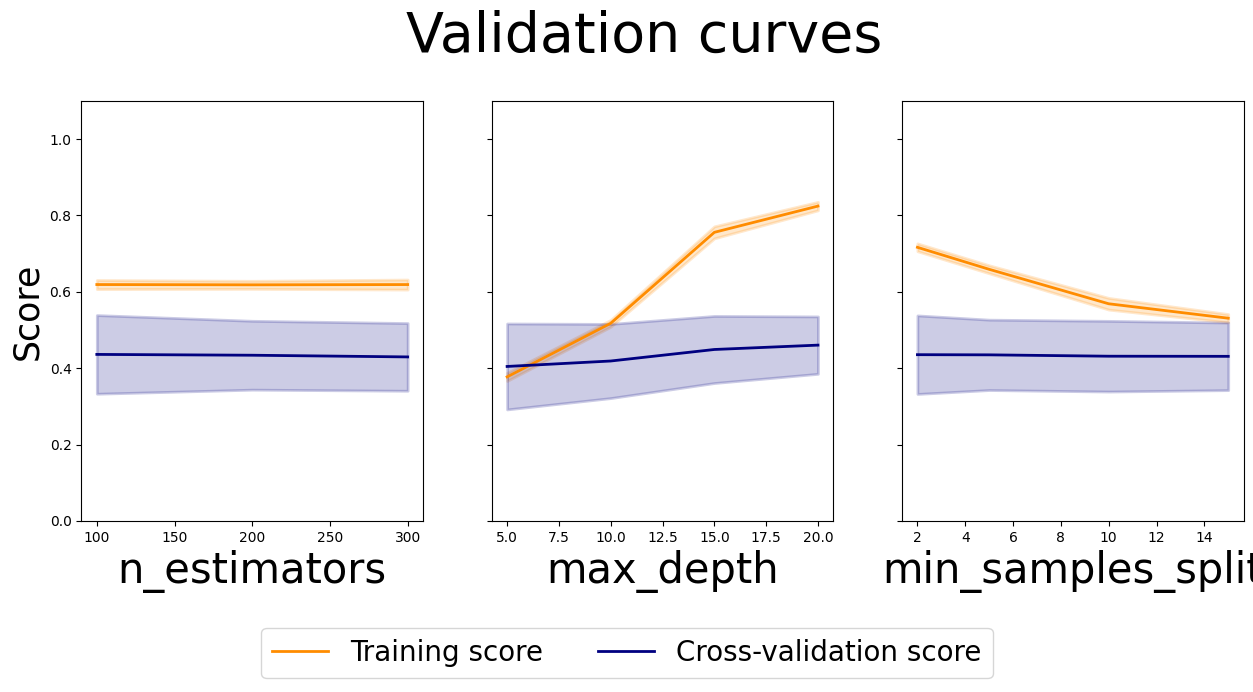

In [16]:
plot_cv_results(rfClassifier.model_cv, rfClassifier.hyper_params[0])